
# AEROSAUR: Smart Air Purifier Integrated with Air Monitoring System

This notebook simulates **AEROSAUR's AI-powered Smart Mode** which automatically adjusts the purifier’s **fan speed** based on environmental conditions and user habits.

---

### Project Overview

AEROSAUR is an AI-powered Smart Air Purifier System that automatically adjusts its fan speed based on real-time environmental data using machine learning. This project develops the Smart Mode model, which predicts the optimal fan speed (0–3) by analyzing air quality readings, previous AQI trends, time of day, and device status. Using a Random Forest Classifier, the model provides high accuracy, robust performance against noisy sensor data, and reliability even with large datasets of up to 500,000 records. Integrated with IoT hardware such as the ESP32 and air quality sensors, the system enables fully automated, efficient, and intelligent air purification suitable for real-world indoor environments.

---


### Proposed Algorithm

**Random Forest Classifier**
- Combines the predictions of many smaller Decision Trees to make one accurate result.
- Each tree looks at random parts of the dataset (time, AQI, temperature, etc.) and “votes” on what fan speed should be.
- The final fan speed prediction is based on the **majority vote** of all trees.

This makes it:
- Highly **robust** against noisy sensor readings.
- Able to **learn user patterns** over time.
- **Accurate** even as conditions change.

---

### Algorithm TIOC (Time, Input, Output, Complexity)

**Time Complexity**

The Smart Mode model uses a **Random Forest Classifier**, which is composed of multiple decision trees. Its complexities are:

**Training Time Complexity**
\[
O( n × T × m × log n)
\]
Where:
- **n** = number of training samples  
- **T** = number of trees
- **m** = umber of features considered at each split (max_features)
- **log n** = average depth factor for splitting

This is efficient even for large datasets, as shown by the successful training on **500,000 records** without system failure.

**Prediction Time Complexity**
\[
O( T × D × m)
\]
Where:
- **T** = number of trees  
- **D** = average tree depth
- **m** = umber of features considered at each split (max_features)

This makes prediction fast and suitable for **real-time IoT device operation**.

**Input**

The model receives the following input features:

- **time** – hour of the day (0–23)
- **aqi_processed** – AQI reading after noise adjustment/filtering
- **aqi_prev** – previous AQI value to reflect short-term trends
- **isPurifierOn** – whether the purifier is currently operating (0 or 1)

These inputs allow the model to understand environmental context, pollution levels, and user behavior patterns.

**Output**

The model predicts the **optimal fan speed level**, represented as:

- **0** – Fan Off  
- **1** – Low Speed  
- **2** – Medium Speed  
- **3** – High Speed  

This output is used directly by the ESP32 microcontroller to adjust the air purifier’s motor speed in real time.

**Complexity**

- The model can process **large datasets (up to 500,000 records)** without crashing, demonstrating high scalability.
- Random Forest is robust to **noisy sensor data**, making it ideal for real-world air quality readings.
- Memory usage remains manageable due to optimized tree structures.
- Prediction is extremely fast, enabling **live, responsive IoT control**.
- Handles **non-linear environmental patterns**, such as sudden AQI spikes or fluctuations caused by airflow, humidity, or human activity.

In [8]:

%pip install pandas numpy scikit-learn matplotlib joblib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# air quality and purifier fan speed simulator

import pandas as pd
import numpy as np

np.random.seed(42)
n = 500000 # dataset size - since nagrerequire lang naman tayo ng quantitave data, di na tayo gumagamit ng csv file for dataset instead we will going to generate our data using np.random function

data = {
    'time': np.random.randint(0, 24, n),
    'aqi': np.random.randint(0, 201, n),
    'isPurifierOn': np.random.choice([0, 1], n)
}

df = pd.DataFrame(data)

noise_std = 2
df['aqi_processed'] = df['aqi'] + np.random.normal(0, noise_std, size=n)

df['aqi_prev'] = df['aqi_processed'].shift(1).fillna(df['aqi_processed'])

def determine_fan_speed(row):
    if row['isPurifierOn'] == 0:
        return 0  
    elif row['aqi'] > 150:
        return 3  
    elif row['aqi'] > 100:
        return 2 
    elif row['aqi'] > 50:
        return 1 
    else:
        return 0 

df['fanSpeed'] = df.apply(determine_fan_speed, axis= 1)

df.head(10)


,time,aqi,isPurifierOn,aqi_processed,aqi_prev,fanSpeed
0,6,187,1,183.652451,183.652451,3
1,19,145,0,144.128706,183.652451,0
2,14,47,0,47.030252,144.128706,0
3,10,24,0,23.510508,47.030252,0
4,7,71,0,72.801994,23.510508,0
5,20,53,1,53.796760,72.801994,1
6,6,9,0,6.599856,53.796760,0
7,18,189,0,189.730934,6.599856,0
8,22,22,0,18.960501,189.730934,0
9,10,78,1,79.071788,18.960501,1


In [ ]:
# fan speed prediction model training and evaluation

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = df[['time', 'aqi_processed', 'aqi_prev', 'isPurifierOn']]

y = df['fanSpeed']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc*100:.2f}%\n")
print(classification_report(y_test, y_pred))

Model Accuracy: 98.73%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     62878
           1       0.97      0.97      0.97     12434
           2       0.97      0.97      0.97     12355
           3       0.98      0.98      0.98     12333

    accuracy                           0.99    100000
   macro avg       0.98      0.98      0.98    100000
weighted avg       0.99      0.99      0.99    100000



In [ ]:
# single-sample fan speed inference

import numpy as np

aqi = 180
aqi_processed = aqi + np.random.normal(0, 2)
aqi_prev = 175
isPurifierOn = 1

sample = pd.DataFrame(
    [[21, aqi_processed, aqi_prev, isPurifierOn]],
    columns=['time', 'aqi_processed', 'aqi_prev', 'isPurifierOn']
)

prediction = model.predict(sample)
print("Predicted Fan Speed:", prediction[0])

Predicted Fan Speed: 3


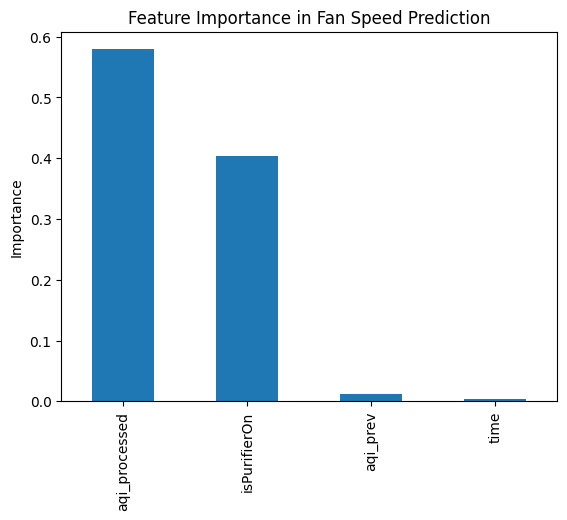

In [ ]:
# feature importance visualization

import matplotlib.pyplot as plt
import pandas as pd

feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp = feat_imp.sort_values(ascending=False)

feat_imp.plot(kind='bar', title='Feature Importance in Fan Speed Prediction')
plt.ylabel('Importance')
plt.show()

In [ ]:
# air quality and fan speed simulation over time

import numpy as np, pandas as pd, time

noise_std = 2
last_aqi_processed = None  

for hour in range(8, 23, 2):
    aqi = np.random.randint(50, 201)

    aqi_processed = aqi + np.random.normal(0, noise_std)

    if last_aqi_processed is None:
        aqi_prev = aqi_processed 
    else:
        aqi_prev = last_aqi_processed

    last_aqi_processed = aqi_processed

    isPurifierOn = 1

    sample = pd.DataFrame(
        [[hour, aqi_processed, aqi_prev, isPurifierOn]],
        columns=['time', 'aqi_processed', 'aqi_prev', 'isPurifierOn']
    )

    speed = model.predict(sample)[0]

    print(f"Time: {hour}:00 | AQI: {aqi} | Predicted Fan Speed: {speed}")
    time.sleep(1)

Time: 8:00 | AQI: 197 | Predicted Fan Speed: 3
Time: 10:00 | AQI: 164 | Predicted Fan Speed: 3
Time: 12:00 | AQI: 127 | Predicted Fan Speed: 2
Time: 14:00 | AQI: 53 | Predicted Fan Speed: 1
Time: 16:00 | AQI: 108 | Predicted Fan Speed: 2
Time: 18:00 | AQI: 155 | Predicted Fan Speed: 3
Time: 20:00 | AQI: 69 | Predicted Fan Speed: 1
Time: 22:00 | AQI: 192 | Predicted Fan Speed: 3


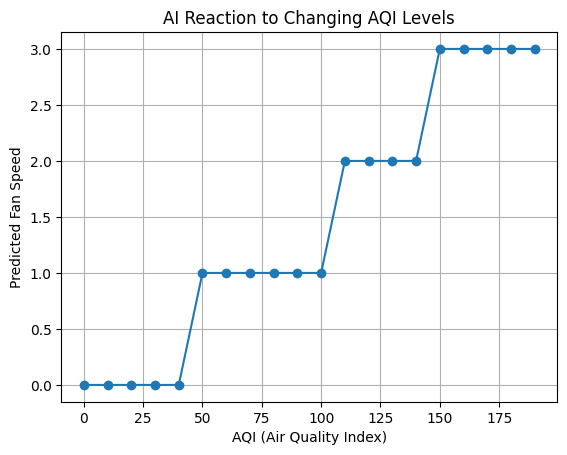

In [ ]:
# ai reaction to changing AQI levels

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

noise_std = 2
last_aqi_processed = None
predicted_speeds = []

aqi_values = np.arange(0, 200, 10)

for aqi in aqi_values:
    aqi_processed = aqi + np.random.normal(0, noise_std)

    if last_aqi_processed is None:
        aqi_prev = aqi_processed
    else:
        aqi_prev = last_aqi_processed

    last_aqi_processed = aqi_processed
    isPurifierOn = 1

    sample = pd.DataFrame(
        [[12, aqi_processed, aqi_prev, isPurifierOn]],
        columns=['time', 'aqi_processed', 'aqi_prev', 'isPurifierOn']
    )

    predicted_speeds.append(model.predict(sample)[0])

plt.plot(aqi_values, predicted_speeds, marker='o')
plt.title("AI Reaction to Changing AQI Levels")
plt.xlabel("AQI (Air Quality Index)")
plt.ylabel("Predicted Fan Speed")
plt.grid(True)
plt.show()